In [1]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

import sys
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Añadir la carpeta principal del repo al path
sys.path.append(os.path.abspath(".."))

LAPTOP = True
if LAPTOP == True:
    path = r'/mnt/d/TFG - Dataset/DATASET/train_1/'
    event = 'event000001000'
    hits, cells, particles, truth = load_event(path + event)

if LAPTOP == False:
    path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
    event = 'event000001000'

print('Loading event {}'.format(path + event))

hits, cells, particles, truth = load_event(path + event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /mnt/d/TFG - Dataset/DATASET/train_1/event000001000
event000001000 memory usage 18.46 MB


# Búsqueda de pares prometedores

In [2]:
# #============== CONSIDERO SOLO LOS HITS DE LA PARTE CENTRAL DEL DETECTOR ==============#
# from commonMLfunctions import hits_vertex
# hits, cells, particles, truth = load_event(path+event)
# hits, particles = hits_vertex(hits, particles, truth)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import resample
from kalman_filter import get_hits_dict
from commonMLfunctions import hits_vertex

PARTICLES_FROM_VERTEX = True  # Si se quiere usar los hits de la parte central del detector
N_events = 100
events = []
for i in range(0, N_events+1):
    event = f'event000001{i:03d}'
    events.append(event)
#events = ['event000001000', 'event000001001', 'event000001002']
print(events)
print(f"Procesando {len(events)} eventos: {events}")

def cone_angle(z, max_angle_deg=6, min_angle_deg=4, z_max=300):
    """
    Ángulo del cono en radianes, que decrece conforme |z| aumenta.

    - Cuando z = 0, el ángulo es máximo (max_angle_deg).
    - Cuando |z| >= z_max, el ángulo es mínimo (min_angle_deg).
    """
    z_abs = abs(z)
    if z_abs >= z_max:
        angle_deg = min_angle_deg
    else:
        # Interpolación lineal decreciente: ángulo grande en z=0, pequeño en z=z_max
        angle_deg = max_angle_deg - (max_angle_deg - min_angle_deg) * (z_abs / z_max)
    return np.deg2rad(angle_deg)


for event in events:
    print(f"\n========================= Procesando evento: {event} =========================\n")
    hits, cells, particles, truth = load_event(path + event)

    hits, particles = hits_vertex(hits, particles, truth, PARTICLES_FROM_VERTEX= PARTICLES_FROM_VERTEX)

    data_dir = '/mnt/d/TFG - Dataset/OUTPUT'
    output_path = os.path.join(data_dir, f'triplets_data_{event}_precise.npz')

    from commonMLfunctions import filtering_by_theta
    # Filtrado de hits por theta
    thetamin, thetamax = filtering_by_theta(hits)

    # Selección de volúmenes
    volume_ids = hits['volume_id'].unique()
    volume_ids = volume_ids[[1, 4, 7]]  
    first_volume = volume_ids[0]

    hits_dict = get_hits_dict(hits, volume_ids, OCTANTE=False, angle_range=(-round(thetamin), round(thetamax)), pt_range = (0.5, np.inf))
    #print(particles.head())
    pt_dict = dict(zip(particles['particle_id'], particles['pt']))  # Cambia 'pt' por el nombre correcto si es diferente

    # Capas
    first_layer = sorted(hits_dict[first_volume].keys())[0]
    second_layer = sorted(hits_dict[first_volume].keys())[1]
    third_layer = sorted(hits_dict[first_volume].keys())[2]

    layer1 = hits_dict[first_volume][first_layer]
    layer2 = hits_dict[first_volume][second_layer]
    layer3 = hits_dict[first_volume][third_layer]

    coords1 = layer1[['x', 'y', 'z']].values
    coords2 = layer2[['x', 'y', 'z']].values
    coords3 = layer3[['x', 'y', 'z']].values

    ids1 = layer1['particle_id'].values
    ids2 = layer2['particle_id'].values
    ids3 = layer3['particle_id'].values


    #cone_angle = np.deg2rad(4)  # en vez de 0.5°

    def angle(v1, v2):
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return np.arccos(np.clip(cos_theta, -1.0, 1.0))

    triplets = []
    labels = []
    pt_values = []

    if os.path.exists(output_path):
        print(f"El archivo {output_path} ya existe. Cargando datos preprocesados...")
        #data = np.load(output_path, allow_pickle=True)
        #X = data['X']
        #y = data['y']
        # Si el archivo ya tiene pt, lo cargas también:
        #if 'pt' in data:
        #    pt_values = data['pt']
        #print(f"Shape de X: {X.shape}, Shape de y: {y.shape}")
        #scaler = data['scaler'].item()  # allow_pickle=True permite .item()
        #print(f"Shape de X: {X.shape}, Shape de y: {y.shape}")


    else:
        print(f"El archivo {output_path} no existe. Generando triplets...")
        from tqdm import tqdm
        
        for i, v1 in enumerate(tqdm(coords1, desc=f"Generando tripletes para {event} ...")):
            id1 = ids1[i]
            angle1 = cone_angle(v1[2])
            for j, v2 in enumerate(coords2):
                id2 = ids2[j]
                if angle(v1, v2) < angle1:
                    angle2 = cone_angle(v2[2])
                    for k, v3 in enumerate(coords3):
                        id3 = ids3[k]
                        if angle(v2, v3) < angle2:
                            triplet = np.stack([v1, v2, v3])
                            label = int(id1 == id2 == id3)
                            triplets.append(triplet)
                            labels.append(label)
                            if label == 1:
                                pt_values.append(pt_dict.get(id1, 0))
                            else:
                                pt_values.append(0)

        triplets = np.array(triplets)
        labels = np.array(labels)

        positive_idx = np.where(labels == 1)[0]
        negative_idx = np.where(labels == 0)[0]

        n_pos = len(positive_idx)
        n_neg = len(negative_idx)

        # Calcular ángulos usados para info
        all_angles_v1 = np.array([cone_angle(v[2]) for v in coords1])
        all_angles_v2 = np.array([cone_angle(v[2]) for v in coords2])

        angles_info_path = os.path.join(data_dir, f'angles_info_{event}.txt')
        with open(angles_info_path, 'w') as f:
            f.write(f"Ángulo máximo usado (v1): {np.rad2deg(np.max(all_angles_v1)):.2f}°\n")
            f.write(f"Ángulo mínimo usado (v1): {np.rad2deg(np.min(all_angles_v1)):.2f}°\n")
            f.write(f"Ángulo máximo usado (v2): {np.rad2deg(np.max(all_angles_v2)):.2f}°\n")
            f.write(f"Ángulo mínimo usado (v2): {np.rad2deg(np.min(all_angles_v2)):.2f}°\n")
        print(f"Info de ángulos guardada en {angles_info_path}")

        import matplotlib.pyplot as plt

        # plt.hist(np.rad2deg(all_angles_v1), bins=30, alpha=0.7, label='Ángulo v1')
        # plt.hist(np.rad2deg(all_angles_v2), bins=30, alpha=0.7, label='Ángulo v2')
        # plt.xlabel('Ángulo (grados)')
        # plt.ylabel('Frecuencia')
        # plt.title(f'Distribución de ángulos para el evento {event}')
        # plt.legend()
        # plt.show()


        BALANCEO = False
        if BALANCEO:
            if n_pos > 0 and n_neg >= n_pos:
                negative_sample = resample(negative_idx, replace=False, n_samples=n_pos, random_state=42)
                selected_idx = np.concatenate([positive_idx, negative_sample])
            elif n_neg < n_pos:
                selected_idx = np.concatenate([positive_idx[:n_neg], negative_idx])
            else:
                selected_idx = np.array([])
            X = triplets[selected_idx]
            y = labels[selected_idx]
            pt_values = pt_values[selected_idx]
            print(f"Después del balanceo:\n Positivos: {np.sum(y == 1)}, Negativos: {np.sum(y == 0)}")
        else:
            X = triplets
            y = labels
            print(f"Sin balanceo: Positivos = {np.sum(y == 1)}, Negativos = {np.sum(y == 0)}")

        ### AL FINAL NO ESCALAMOS AQUÍ SINO CUANDO AGRUPEMOS EN UN SOLO ARCHIVO TODOS LOS TRIPLETES

        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        #X_scaled = X.reshape(X.shape[0], -1)
        X_original = X.reshape(X.shape[0], -1)  # Guardar antes de escalar
        #scaler = MinMaxScaler()
        #X_scaled = scaler.fit_transform(X_original)

        np.savez(output_path, 
                X=X_original,
                y=y)  
        import joblib
        #joblib.dump(scaler, 'scaler.pkl')  # o 'scaler.pkl'
        file_size_mb = os.path.getsize(output_path) / (1024 * 1024)  # Tamaño en MB
        print(f"Datos guardados en {output_path}.\n\tTamaño del archivo generado: {file_size_mb:.2f} MB")

module://matplotlib_inline.backend_inline
@common.py:  
	set random seed
		SEED=35202
	set cuda environment
		torch.__version__              = 2.7.1+cu126
		torch.version.cuda             = 12.6
		torch.backends.cudnn.version() = 90501
		os['CUDA_VISIBLE_DEVICES']     = None
		torch.cuda.device_count()      = 1
		torch.cuda.current_device()    = 0

['event000001000', 'event000001001', 'event000001002', 'event000001003', 'event000001004', 'event000001005', 'event000001006', 'event000001007', 'event000001008', 'event000001009', 'event000001010', 'event000001011', 'event000001012', 'event000001013', 'event000001014', 'event000001015', 'event000001016', 'event000001017', 'event000001018', 'event000001019', 'event000001020', 'event000001021', 'event000001022', 'event000001023', 'event000001024', 'event000001025', 'event000001026', 'event000001027', 'event000001028', 'event000001029', 'event000001030', 'event000001031', 'event000001032', 'event000001033', 'event000001034', 'event000001035', 

In [ ]:
import os
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
data_dir = '/mnt/d/TFG - Dataset/OUTPUT'
combined_X_original = []
combined_y = []

INDIVIDUAL_EVENTS = False

N_events = 100  # Número total de eventos a combinar
# Recorre todos los archivos de tripletes
for i in range(1, N_events+1):
    event = f'event0000010{i:02d}'
    path = os.path.join(data_dir, f'triplets_data_{event}_precise.npz')

    if not os.path.exists(path):
        print(f"ERROR: Archivo no encontrado: {path}")
        continue

    print(f"Cargando {path}...")
    data = np.load(path, allow_pickle=True)
    X_original = data['X']  # Datos antes del escalado
    y = data['y']

    combined_X_original.append(X_original)
    combined_y.append(y)

# Combina todos
X_all_original = np.vstack(combined_X_original)
y_all = np.concatenate(combined_y)

# Escala todos los datos originales juntos
scaler = MinMaxScaler()
X_all_scaled = scaler.fit_transform(X_all_original)

# BALANCEO GLOBAL
from sklearn.utils import resample

BALANCEO_GLOBAL = False  # Si vemos un claro desbalance de clases

if BALANCEO_GLOBAL:
    positive_idx = np.where(y_all == 1)[0]
    negative_idx = np.where(y_all == 0)[0]

    n_pos = len(positive_idx)
    n_neg = len(negative_idx)

    print(f"\nRealizando balanceo global:")
    print(f"Positivos: {n_pos}, Negativos: {n_neg}")

    if n_pos > 0 and n_neg >= n_pos:
        negative_sample = resample(negative_idx, replace=False, n_samples=n_pos, random_state=42)
        selected_idx = np.concatenate([positive_idx, negative_sample])
    elif n_neg < n_pos:
        positive_sample = resample(positive_idx, replace=False, n_samples=n_neg, random_state=42)
        selected_idx = np.concatenate([positive_sample, negative_idx])
    else:
        selected_idx = np.array([])  # No balanceable

    # Reorganizar los datos
    X_all_scaled = X_all_scaled[selected_idx]
    X_all_original = X_all_original[selected_idx]
    y_all = y_all[selected_idx]

    print(f"Después del balanceo global:\n Positivos: {np.sum(y_all==1)}, Negativos: {np.sum(y_all==0)}")
else:
    print(f"\nSin balanceo global:\n Positivos: {np.sum(y_all==1)}, Negativos: {np.sum(y_all==0)}")


print(f"\nTotal de tripletes combinados: {X_all_scaled.shape[0]}")
print(f"Positivos: {np.sum(y_all==1)}")
print(f"Negativos: {np.sum(y_all==0)}")

# Guarda el conjunto combinado escalado
combined_path = os.path.join(data_dir, 'triplets_data_combined_precise.npz')
np.savez(combined_path, X=X_all_scaled, y=y_all, triplets_original=X_all_original)
joblib.dump(scaler, os.path.join(data_dir, 'scaler_combined_precise.pkl'))

print(f"\nDatos combinados guardados en: {combined_path}")
print(f"Scaler global guardado en: {os.path.join(data_dir, 'scaler_combined_precise.pkl')}")


Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001001_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001002_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001003_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001004_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001005_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001006_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001007_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001008_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001009_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001010_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001011_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001012_precise.npz...
Cargando /mnt/d/TFG - Datase

Datos cargados: X=(255932, 9), y=(255932,)
Positivos: 127966	Negativos: 127966
Entrenando el modelo con tripletes combinados...
Shape de X: (255932, 9)	 Shape de y: (255932,)

Positivos: 127966	 Total negatives: 127966
Dataset original length: 255932
Train subset length: 230338
Val subset length: 25594


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/500 completed.
	Train Loss: 0.5645, Train Acc: 0.7014
	Validation Loss: 0.6455, Validation Acc: 0.6899
	Time elapsed: 00:01:03
- Epoch 2/500 completed.
	Train Loss: 0.2134, Train Acc: 0.9195
	Validation Loss: 0.1611, Validation Acc: 0.9437
	Time elapsed: 00:02:07
- Epoch 3/500 completed.
	Train Loss: 0.1393, Train Acc: 0.9532
	Validation Loss: 0.1199, Validation Acc: 0.9617
	Time elapsed: 00:03:06
- Epoch 4/500 completed.
	Train Loss: 0.1073, Train Acc: 0.9658
	Validation Loss: 0.0942, Validation Acc: 0.9710
	Time elapsed: 00:04:09
- Epoch 5/500 completed.
	Train Loss: 0.0903, Train Acc: 0.9716
	Validation Loss: 0.0849, Validation Acc: 0.9741
	Time elapsed: 00:05:12
- Epoch 6/500 completed.
	Train Loss: 0.0792, Train Acc: 0.9757
	Validation Loss: 0.0954, Validation Acc: 0.9708
	Time elapsed: 00:06:14
- Epoch 7/500 completed.
	Train Loss: 0.0721, Train Acc: 0.9781
	Validation Loss: 0.0704, Validation Acc: 0.9791
	Time elapsed: 00:07:14
- Epoch 8/500 completed.
	Train Loss: 0.0

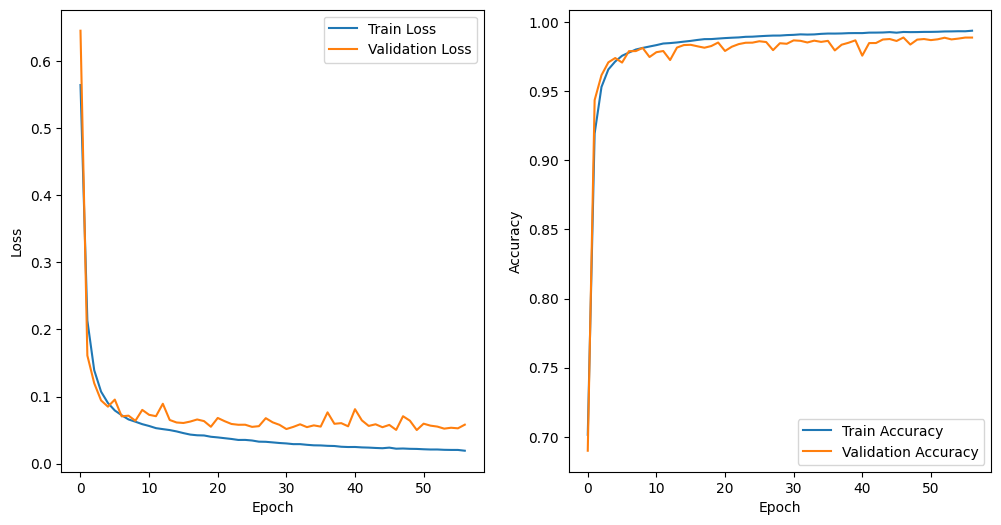

In [8]:
from model import TripletNet, SimpleNet
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from commonMLfunctions import TripletDataset, create_dataloaders
from common import *
from commonMLfunctions import write_metrics_to_log, training_triplet_model, predict_all

%matplotlib inline

LOAD_TRAINED_MODEL = False

if not os.path.exists(combined_path):
    raise FileNotFoundError(f"No se encuentra el archivo combinado: {combined_path}")

data = np.load(combined_path, allow_pickle=True)
X = data['X']
y = data['y']
#pt = data['pt']

print(f"Datos cargados: X={X.shape}, y={y.shape}")
print(f"Positivos: {np.sum(y == 1)}\tNegativos: {np.sum(y == 0)}")

if not LOAD_TRAINED_MODEL:
    model = None  # Inicializa el modelo vacío
    best_f1 = 0

    # Si se quiere entrenar con múltiples eventos
    if INDIVIDUAL_EVENTS:
        print("Entrenando el modelo con múltiples eventos...")
        for event in events[1,-1]:
            print(f"\n========================= Cargando datos para el evento: {event} =========================\n")

            # Verificamos si el archivo existe
            if not os.path.exists(output_path):
                print(f"El archivo triplets_data_{event}.npz no existe. Por favor, genera los triplets primero.")
                continue

            # Entrenamos y actualizamos el modelo con el evento actual
            model = training_triplet_model(event, model=model)
            print(f"Modelo actualizado con el evento {event}.\n")

            # y_true, y_pred = predict_all(model, val_loader)
            # f1 = f1_score(y_true, y_pred)
            # if f1 > best_f1:
            #     best_f1 = f1
            #     torch.save(model.state_dict(), f'best_model.pth')
            # #torch.save(model.state_dict(), f'model_after_{event}.pth')

    else:
        print("Entrenando el modelo con tripletes combinados...")
        event = 'combined_precise'
        model = training_triplet_model(event, model=model)


    # Guardamos el modelo final con fecha y hora
    from datetime import datetime
    current_time = datetime.now().strftime("%m%d_%H%M%S")
    model_save_name = f'triplet_model_{current_time}.pth'

    model_save_path = os.path.join('/home/alvar/repositorioTFG/ML_trackfinding', model_save_name)

    torch.save(model.state_dict(), model_save_path)


## Evaluación del modelo final

In [9]:
import torch
from model import TripletNet
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from commonMLfunctions import create_dataloaders
import numpy as np
import os
import joblib  

# === Cargar el modelo ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet().to(device)
if LOAD_TRAINED_MODEL:
    #model_save_path = '/home/alvar/repositorioTFG/ML_trackfinding/triplet_model_0702_015140.pth'
    #model_save_path = '/home/alvar/repositorioTFG/ML_trackfinding/triplet_model_0702_225509.pth'
    #model_save_path = '/home/alvar/repositorioTFG/ML_trackfinding/triplet_model_0702_230025.pth'
    model_save_path = '/home/alvar/repositorioTFG/ML_trackfinding/triplet_model_0704_233100.pth'
    
    trained_model_path = model_save_path
    model.load_state_dict(torch.load(trained_model_path, map_location=device))
else:
    model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# === Cargar datos de validación ===
if not INDIVIDUAL_EVENTS:
    event = 'event000001000'
    base_path = "/mnt/d/TFG - Dataset/OUTPUT"
    file_name = f"triplets_data_{event}_precise.npz"
    data_path = os.path.join(base_path, file_name)

    data = np.load(data_path)
else:
    data = np.load(combined_path, allow_pickle=True)

# === Cargar scaler y transformar datos ===
scaler_path = os.path.join(base_path, 'scaler_combined_precise.pkl')
scaler = joblib.load(scaler_path)
X_scaled = scaler.transform(data["X"])

# X = torch.tensor(X_scaled, dtype=torch.float32)
# y = torch.tensor(data["y"], dtype=torch.float32)

X = torch.from_numpy(X_scaled).float()
y = torch.from_numpy(data["y"]).float()

from torch.utils.data import DataLoader, TensorDataset

full_dataset = TensorDataset(X, y)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

# === Evaluación ===
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for x_batch, y_batch in full_loader:
        x_batch = x_batch.to(device)
        logits = model(x_batch)
        preds = (torch.sigmoid(logits) > 0.5).float().cpu()
        y_true_all.append(y_batch.cpu())
        y_pred_all.append(preds)

y_true = torch.cat(y_true_all).numpy()
y_pred = torch.cat(y_pred_all).numpy()

# === Métricas ===
print("\n=== Evaluación del modelo final ===")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))



=== Evaluación del modelo final ===
Accuracy:  0.9821
Precision: 0.5636
Recall:    0.9977
F1-score:  0.7203

Confusion Matrix:
[[71325  1324]
 [    4  1710]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9999    0.9818    0.9908     72649
         1.0     0.5636    0.9977    0.7203      1714

    accuracy                         0.9821     74363
   macro avg     0.7818    0.9897    0.8555     74363
weighted avg     0.9899    0.9821    0.9845     74363



X_triplets_scaled stats antes de desescalar:
Min: tensor(-1.2785e-05) Max: tensor(1.0000) Mean: tensor(0.5131)
X_triplets_flat shape: (74363, 9)
X_triplets_descaled_flat stats después de desescalar:
Min: -489.201 Max: 490.63104 Mean: 1.8840463
Original: TP=1710, TN=71325, FP=1324, FN=4
Mostrando: TP=11, TN=480, FP=8, FN=1
Accuracy: 98.2142%
F1 Score: 0.7203


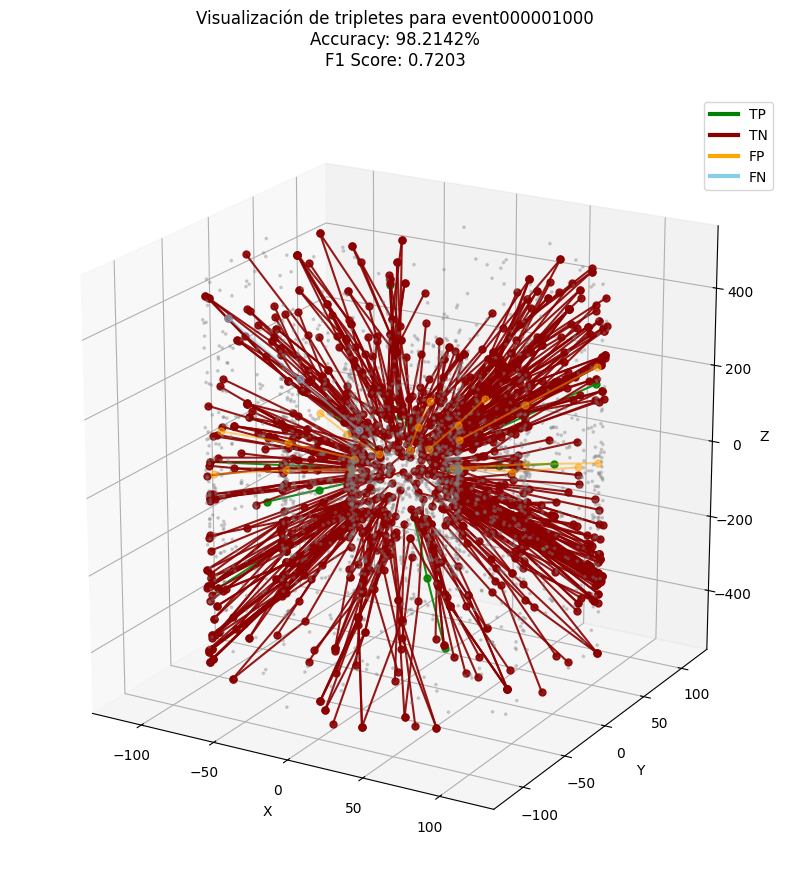

In [10]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
import joblib

scaler = joblib.load(os.path.join(data_dir, 'scaler_combined_precise.pkl'))  # Cargamos el scaler del archivo npz
y_true = torch.cat(y_true_all).numpy()
y_pred = torch.cat(y_pred_all).numpy()

def visualize_triplets_by_accuracy_sampled(X_triplets_scaled, y_true, y_pred, scaler,
                                          title='Visualización por accuracy', total_to_show=100):
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    min_len = min(len(y_true), len(y_pred), len(X_triplets_scaled))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    X_triplets_scaled = X_triplets_scaled[:min_len]

    print("X_triplets_scaled stats antes de desescalar:")
    print("Min:", X_triplets_scaled.min(), "Max:", X_triplets_scaled.max(), "Mean:", X_triplets_scaled.mean())

    # Convertimos a numpy si es tensor
    X_triplets_flat = X_triplets_scaled.reshape(min_len, -1)
    if hasattr(X_triplets_flat, "cpu"):  # Detecta si es tensor PyTorch
        X_triplets_flat = X_triplets_flat.cpu().numpy()
    else:
        X_triplets_flat = np.array(X_triplets_flat)

    print("X_triplets_flat shape:", X_triplets_flat.shape)

    X_triplets_descaled_flat = scaler.inverse_transform(X_triplets_flat)

    print("X_triplets_descaled_flat stats después de desescalar:")
    print("Min:", X_triplets_descaled_flat.min(), "Max:", X_triplets_descaled_flat.max(), "Mean:", X_triplets_descaled_flat.mean())

    X_triplets_descaled = X_triplets_descaled_flat.reshape(min_len, 3, 3)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(layer1.x, layer1.y, layer1.z, c='gray', alpha=0.3, s=3, label='Layer 1')
    ax.scatter(layer2.x, layer2.y, layer2.z, c='gray', alpha=0.3, s=3, label='Layer 2')
    ax.scatter(layer3.x, layer3.y, layer3.z, c='gray', alpha=0.3, s=3, label='Layer 3')


    ax.set_box_aspect([1, 1, 1])
    ax.view_init(elev=20, azim=-60)

    tp_idx = np.where((y_true == 1) & (y_pred == 1))[0]
    tn_idx = np.where((y_true == 0) & (y_pred == 0))[0]
    fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]
    fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]

    counts = {'TP': len(tp_idx), 'TN': len(tn_idx), 'FP': len(fp_idx), 'FN': len(fn_idx)}
    total = sum(counts.values())
    proportions = {k: v / total for k, v in counts.items()}

    sampled_counts = {k: max(1, int(proportions[k] * total_to_show)) for k in proportions}
    difference = total_to_show - sum(sampled_counts.values())
    if difference != 0:
        sorted_keys = sorted(counts.items(), key=lambda x: -x[1])
        for k, _ in sorted_keys:
            sampled_counts[k] += difference
            break

    sampled = {
        'TP': random.sample(list(tp_idx), min(sampled_counts['TP'], len(tp_idx))),
        'TN': random.sample(list(tn_idx), min(sampled_counts['TN'], len(tn_idx))),
        'FP': random.sample(list(fp_idx), min(sampled_counts['FP'], len(fp_idx))),
        'FN': random.sample(list(fn_idx), min(sampled_counts['FN'], len(fn_idx))),
    }

    def plot_triplets(indices, color, alpha):
        for i in indices:
            triplet = X_triplets_descaled[i]
            ax.plot(triplet[:, 0], triplet[:, 1], triplet[:, 2], c=color, alpha=alpha, marker='o', markersize=5)

    plot_triplets(sampled['TP'], 'green', 0.9)
    plot_triplets(sampled['TN'], 'darkred', 0.9)
    plot_triplets(sampled['FP'], 'orange', 0.5)
    plot_triplets(sampled['FN'], 'skyblue', 0.5)

    acc = (counts['TP'] + counts['TN']) / total if total else 0.0

    print(f"Original: TP={counts['TP']}, TN={counts['TN']}, FP={counts['FP']}, FN={counts['FN']}")
    print(f"Mostrando: TP={len(sampled['TP'])}, TN={len(sampled['TN'])}, FP={len(sampled['FP'])}, FN={len(sampled['FN'])}")
    print(f"Accuracy: {acc:.4%}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

    ax.set_title(f"{title}\nAccuracy: {acc:.4%}\nF1 Score: {f1_score(y_true, y_pred):.4f}\n")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    handles = [
        plt.Line2D([0], [0], color='green', lw=3),
        plt.Line2D([0], [0], color='darkred', lw=3),
        plt.Line2D([0], [0], color='orange', lw=3),
        plt.Line2D([0], [0], color='skyblue', lw=3)
    ]
    labels = ['TP', 'TN', 'FP', 'FN']
    ax.legend(handles, labels)
    # ax.set_xlim(-100, 100)
    # ax.set_ylim(-100, 100)
    # ax.set_zlim(-400, 400)

    # Ajustar la proporción del cuadro para que cada unidad sea igual en X, Y, Z
    #ax.set_box_aspect([200, 200, 800])  # proporción del tamaño real:  x_range, y_range, z_range

    plt.show()
    return X_triplets_descaled, X_triplets_descaled_flat


# Visualizar tripletes por accuracy
X_triplets_descaled, X_triplets_descaled_flat = visualize_triplets_by_accuracy_sampled(X, y_true, y_pred, scaler, 
                                        title=f'Visualización de tripletes para {event}', 
                                        total_to_show=500)

# filename = f'triplets_trained_{event}_modelo_pesado.npz'
# save_path = os.path.join(data_dir, filename)

# # Guardamos el array con compresión
# np.savez(save_path, triplets=X_triplets_descaled)

# print(f"Archivo guardado en: {save_path}")